# Plot

## Librairies

In [368]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import re

import numpy as np
from scipy.spatial import ConvexHull
from scipy.stats import skew, kurtosis

import pandas as pd
import seaborn as sns

import pickle

from source.bgt_network import *
from source.network import *
from source.attractors import *
from optim.simulated_annealing import *

import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Build dataset

We generate random weight matrices $W$ (with input weights being all $1$) and study their number of attractors as a function of the algebraic properties.

In [395]:
def generate_weight_matrices(n_inputs=1, n_cells=5, bound=1.0):
    
    A = np.random.uniform(low=-bound, high=bound, size=(n_cells, n_cells))
    B1 = np.ones((n_inputs, n_cells))   # unit input weights
    B2 = np.zeros((n_cells, n_inputs))  # no interactive connections
    b = np.zeros(shape=(n_cells, 1))    # !!! we assume zero bias !!!
    x = "dummy initial state"

    return [A, B1, B2, b, x]

In [396]:
def compute_matrix_features(M_list):
    """
    Computes numerical features from the eigenvalues of a list of matrices.
    
    Parameters:
        M_list (list of np.ndarray): List of square matrices M_i.
    
    Returns:
        np.ndarray: Feature matrix of shape (num_matrices, num_features).
    """
    features = []

    for M in M_list:
        # Compute eigenvalues
        rank = np.linalg.matrix_rank(M)
        eigvals = np.linalg.eigvals(M)
        real_parts = np.real(eigvals)
        imag_parts = np.imag(eigvals)
        abs_eigvals = np.abs(eigvals)

        # Feature extraction
        feature_vector = []

        # 1. Statistical features of real and imaginary parts
        for values in [real_parts, imag_parts]:
            feature_vector.extend([
                rank, np.mean(values), np.std(values), np.min(values), np.max(values),
                skew(values), kurtosis(values)
            ])

        # 2. Spectral properties
        feature_vector.extend([
            np.trace(M),                     # Sum of eigenvalues
            np.linalg.det(M),                # Product of eigenvalues
            np.max(abs_eigvals),             # Spectral radius
            np.ptp(abs_eigvals),             # Eigenvalue spread (max - min)
            np.linalg.cond(M) if np.linalg.matrix_rank(M) == M.shape[0] else np.inf
        ])

        # 3. Geometric properties of eigenvalues
        eigen_points = np.column_stack((real_parts, imag_parts))  # Eigenvalues as (x, y) points

        if len(eigen_points) >= 3:  # Convex hull is defined for 3+ points
            try:
                hull = ConvexHull(eigen_points)
                feature_vector.append(hull.area)
            except:
                feature_vector.append(0)  # Handle degenerate cases
        else:
            feature_vector.append(0)

        # 4. Count-based features
        num_real = np.sum(imag_parts == 0)
        num_imaginary = len(imag_parts) - num_real
        feature_vector.extend([num_real, num_imaginary, num_real / (num_imaginary + 1e-6)])

        features.append(feature_vector)

    return np.array(features)


In [378]:
# Build dataset
np.random.seed(42)

# features
M_list = []

for i in range(20000):

    M = generate_weight_matrices(n_inputs=1, n_cells=5, bound=1.0)
    M_list.append(M[0])

features = compute_matrix_features(M_list)

# targets
M0 = generate_weight_matrices(n_inputs=1, n_cells=5, bound=1.0)
M_tensor = np.stack([M for M in M_list], axis=2)
targets = np.array(get_nb_attractors(M_tensor, M0))


# Print shape of the feature matrix (should be 10 × num_features)
print("Feature matrix shape:", features.shape)
print("Target matrix shape:", targets.shape)

Feature matrix shape: (20000, 23)
Target matrix shape: (20000,)


## Feature-Target Relationship Analysis

In [389]:
df = pd.DataFrame(features, columns=[f'feat_{i}' for i in range(features.shape[1])])
df['target'] = targets  # Add target values to DataFrame

In [397]:
df.target.unique()

array([  4,   3,   6,  19,   5,   0,  13,  11,   8,  17,  14,  10,  12,
         9,   7,  16,  22,  29,  20,  25,  15,   2,  18,  40,  26,  28,
        21,  41,  24,  27,  35,  43,  46,  48,  30,  33,   1,  32,  23,
        37,  31,  52,  42,  45,  34,  79,  44,  47,  88,  38,  36, 140,
        54,  59,  39,  66,  50, 115,  60])

In [390]:
df.isna().sum()

feat_0       0
feat_1       0
feat_2       0
feat_3       0
feat_4       0
feat_5       0
feat_6       0
feat_7       0
feat_8       0
feat_9       0
feat_10      0
feat_11      0
feat_12    525
feat_13    525
feat_14      0
feat_15      0
feat_16      0
feat_17      0
feat_18      0
feat_19      0
feat_20      0
feat_21      0
feat_22      0
target       0
dtype: int64

In [391]:
df = df.drop(columns=['feat_12', 'feat_13'])
df.isna().sum().sum()

np.int64(0)

### Target Distribution

[]

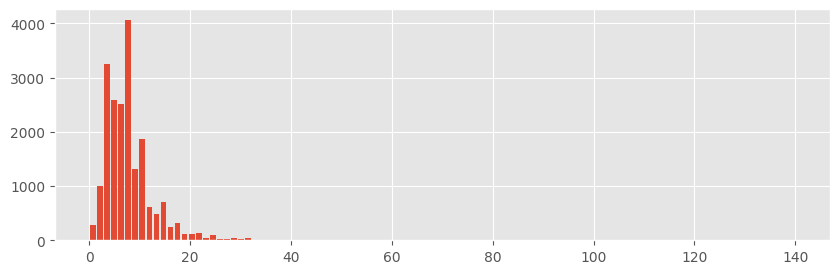

In [392]:
plt.figure(figsize=(10, 3))
plt.hist(df.target, bins=100, rwidth=0.8)
plt.plot()

### Correlation Analysis

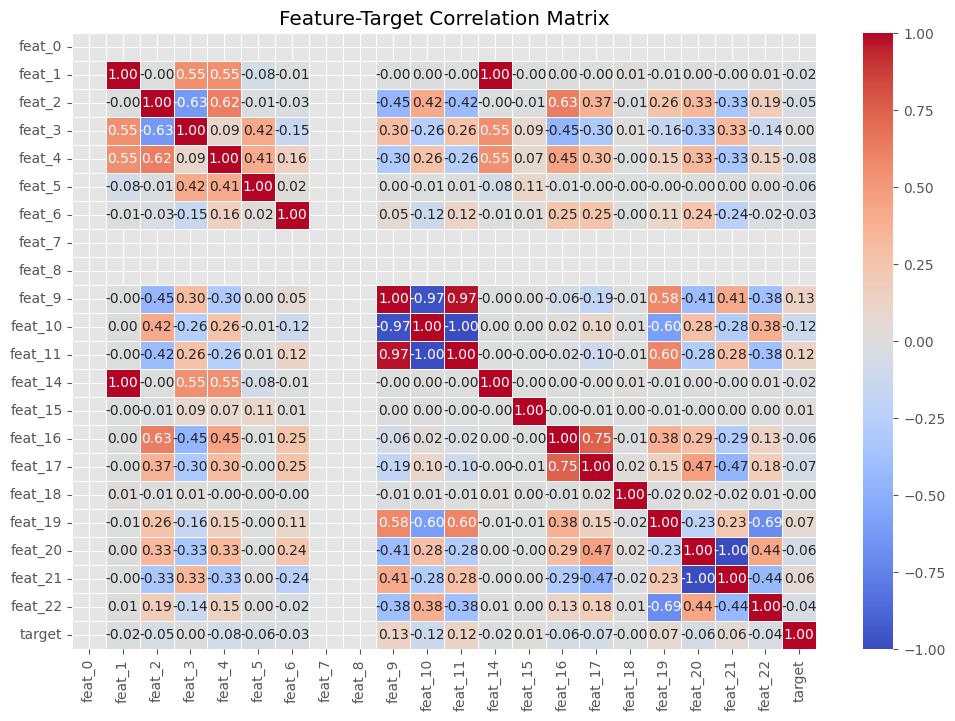

In [393]:
corr_matrix = df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature-Target Correlation Matrix")
plt.show()


In [394]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(df.drop(columns=["target"]), df.target)
print("Mutual Information Scores:", mi)

Mutual Information Scores: [0.00000000e+00 1.00135065e-02 1.18838540e-02 0.00000000e+00
 2.70245828e-02 6.22215845e-03 7.44370104e-03 0.00000000e+00
 0.00000000e+00 1.02636702e-02 1.38944269e-02 1.45456142e-02
 1.00135065e-02 0.00000000e+00 9.23174474e-03 0.00000000e+00
 0.00000000e+00 3.96362976e-04 6.38513816e-03 7.22309802e-05
 6.23826214e-04]


### Visualizing Feature Distributions Across Targets

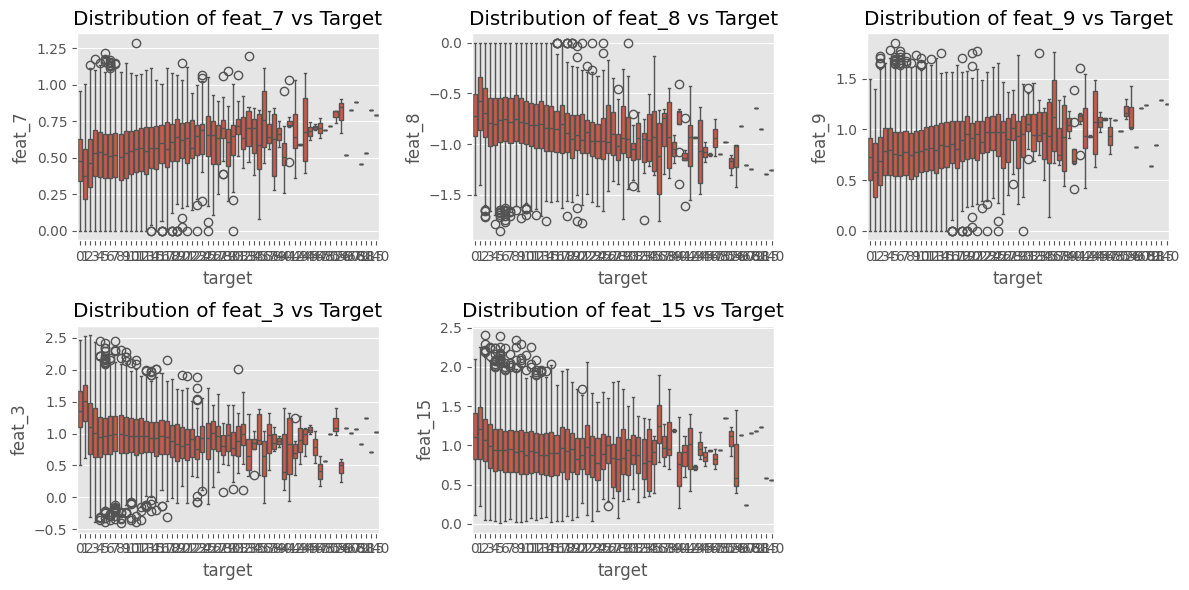

In [335]:
top_features = corr_matrix['target'].abs().sort_values(ascending=False).index[1:6]  # Top 5 features

plt.figure(figsize=(12, 6))
for i, feat in enumerate(top_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df['target'], y=df[feat])
    plt.title(f'Distribution of {feat} vs Target')
plt.tight_layout()
plt.show()

### Feature Importance via a Simple Model

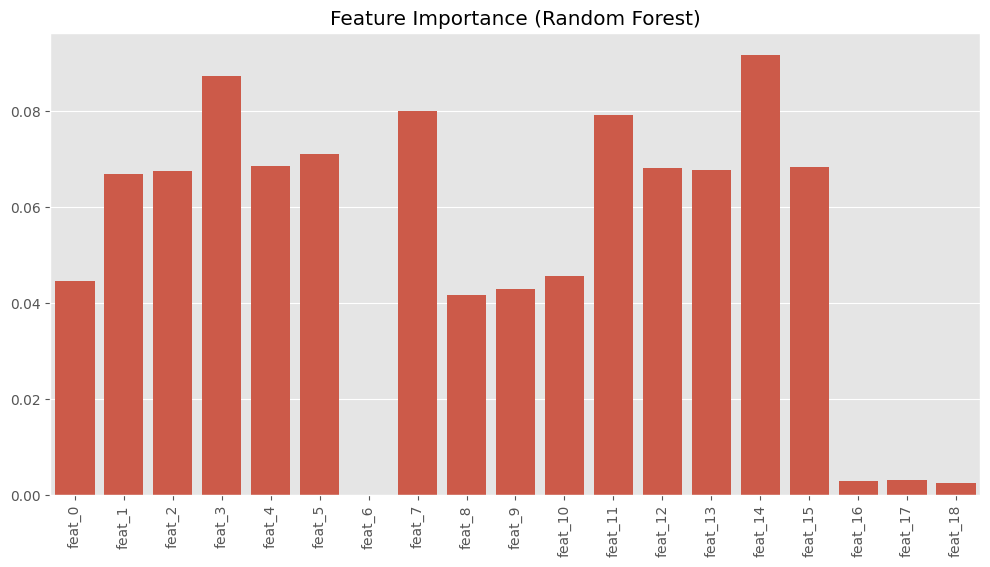

In [336]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=42)

# Choose model based on target type
if y_train.nunique() > 10:  # Assume regression if many unique values
    model = RandomForestRegressor(n_estimators=100, random_state=42)
else:
    model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model & compute feature importances
model.fit(X_train, y_train)
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=[f'feat_{i}' for i in range(len(importances))], y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.show()

### t-SNE

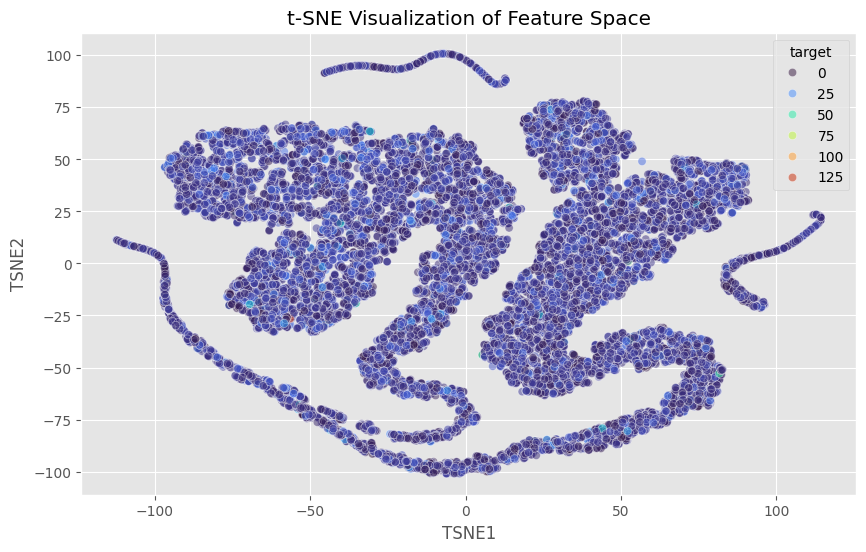

In [337]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Extract feature matrix (excluding target column)
X = df.drop(columns=['target'])
y = df['target']

# Run t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

# Convert to DataFrame for easy plotting
tsne_df = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'])
tsne_df['target'] = y

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue=y, palette="turbo", alpha=0.5)
plt.title("t-SNE Visualization of Feature Space")
plt.show()